# Create XGBoost Model  

Given the tokenization encoding from **BAAI/bge-small-en-v1.5** and some of the attributes from the post, predict whether the post is negative, positive, or neutral

In [1]:
# !pip install -r ../requirements.txt


In [ ]:
model = "BAAI/bge-small-en-v1.5"

In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import sys 
import requests

sys.path.append('../scripts/')

2025-04-03 18:47:38.187451: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
pd.set_option('display.max_rows', 100)

In [4]:
random_state = 13

In [5]:
from access_data import authenticate_google_drive, grab_google_drive_folder_data

drive = authenticate_google_drive()
text_data = grab_google_drive_folder_data(drive=drive,filename="combined_labeled_data.csv")

Successfully loaded 'combined_labeled_data.csv' into a DataFrame!


In [19]:
%%time 

def create_embedding_dataframes(post_dataset, model, col_to_encode='combine_text'):

    dataset = post_dataset.copy().reset_index(drop=True)
    text_to_encode = post_dataset[col_to_encode]
    
    data_with_embdedding = pd.DataFrame()
    print('Started with model ' + model)
    load_model = SentenceTransformer(model, device="cpu") 
    post_embedding = load_model.encode(text_to_encode.values)
    data_with_embdedding = pd.concat([dataset, pd.DataFrame(post_embedding)], axis = 1)
    print('Done with model: ' + model)

    return data_with_embdedding
    
embedded_df = create_embedding_dataframes(text_data, model)


Started with model BAAI/bge-small-en-v1.5
Done with model: BAAI/bge-small-en-v1.5
CPU times: user 17.3 s, sys: 2.02 s, total: 19.3 s
Wall time: 3.06 s


In [20]:
embedded_df.isna().sum()

submission_id      0
subreddit_topic    0
search_query       0
combine_text       0
url                0
                  ..
379                0
380                0
381                0
382                0
383                0
Length: 391, dtype: int64

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report
import xgboost as xgb

In [22]:
# ================================
# Feature Prep & Split Data 
# ================================
label_mapping = {
    'Neutral': 0,
    'Negative': 1,
    'Positive': 2
}
embedded_df['label_encode'] = embedded_df['label'].map(label_mapping)

ids = ['submission_id']
tokenization_columns_numerical = list(embedded_df.columns)[7:]
categorical = ['subreddit_topic', 'search_query']
features = tokenization_columns_numerical + categorical
target = 'label_encode'

# Prevent data leakage 
if target in features: 
    features.remove(target)

X = embedded_df[features]
y = embedded_df[target]
id_df = embedded_df[ids]

# Enable Categorical 
for cat in categorical: 
    X[cat] = X[cat].astype("category") 
    embedded_df[cat] = embedded_df[cat].astype("category")

X_train, X_test, y_train, y_test, id_train, id_test  = train_test_split(X, y, id_df, test_size=0.33, random_state=random_state,  stratify=y)


/tmp/ipykernel_12078/2784456606.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")
/tmp/ipykernel_12078/2784456606.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")


In [23]:
import numpy as np
import pandas as pd 
import xgboost as xgb
# ================================
# Handle Class Imbalance & Create model pipeline
# ================================
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print("Class Weights:", class_weights)

# Fit the model with sample weights
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

model = xgb.XGBClassifier(
    objective='multi:softmax',       
    num_class=3,                      
    eval_metric='mlogloss',           
    random_state=random_state,
    enable_categorical=True
)

model.fit(X_train, y_train)


Class Weights: [ 0.40384615  2.1        21.        ]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [24]:
X_train.columns

Index([                0,                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,                 8,
                       9,
       ...
                     376,               377,               378,
                     379,               380,               381,
                     382,               383, 'subreddit_topic',
          'search_query'],
      dtype='object', length=386)

Training Dataset:
 |    |   label_encode |
|---:|---------------:|
|  0 |             52 |
|  1 |             10 |
|  2 |              1 |
Testing Dataset:
 |    |   label_encode |
|---:|---------------:|
|  0 |             26 |
|  1 |              5 |
|  2 |              1 |
f1-score: 0.3742424242424242


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


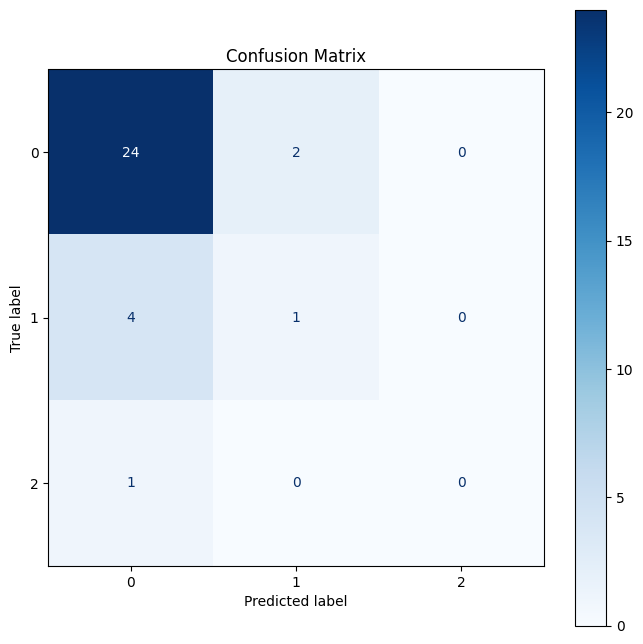

In [25]:
# ================================
# Evaluate the Model 
# ================================
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Training Dataset:\n", y_train.value_counts().to_markdown())
print("Testing Dataset:\n", y_test.value_counts().to_markdown())

y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred)
f1_score = f1_score(y_test, y_pred, average='macro')
print(f"f1-score: {f1_score}")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Get outputs

In [10]:
final_data = pd.DataFrame() 
final_data['submission_id'] = id_test['submission_id']
final_data[['subredit_topic', 'search_query']] = X_test[['subredit_topic', 'search_query']]
final_data[['neutral', 'negative', 'positive']] = model.predict_proba(X_test)
final_data['class_pred']  = model.predict(X_test)



In [11]:
final_data = final_data.rename(columns={'subredit_topic': 'subreddit_topic'})
final_data.head() 


,submission_id,subreddit_topic,search_query,neutral,negative,positive,class_pred
64,1iied6m,IRS,Turbo Tax,0.977134,0.020386,0.002480,0
97,1fury2p,Banking,Wells Fargo,0.429232,0.548512,0.022256,1
110,1gum4oc,FirstTimeHomeBuyer,Rocket Mortgage,0.997818,0.000892,0.001290,0
70,191leob,FirstTimeHomeBuyer,Rocket Mortgage,0.927970,0.051890,0.020140,0
72,19bd4r0,FirstTimeHomeBuyer,Rocket Mortgage,0.996936,0.001099,0.001965,0


In [ ]:
# from access_data import authenticate_google_drive, save_google_drive_data

# drive = authenticate_google_drive()
# save_google_drive_data(drive=drive, 
#                        dataframe =final_data, 
#                        filename="xgboost_bge_test_predictions.csv")

## Score all 5,000 posts

In [24]:
# final_data.columns

Index(['submission_id', 'subreddit_topic', 'search_query', 'neutral',
       'negative', 'positive', 'class_pred'],
      dtype='object')

In [25]:
# all_scored = data.copy(deep=True)

# all_scored['class_pred'] = model.predict(data[features])
# all_scored[['neutral', 'negative', 'positive']] = model.predict_proba(data[features])
# all_scored['class_pred']  = model.predict(data[features])

# all_scored.rename(columns={'subredit_topic': 'subreddit_topic'}, inplace=True)
# columns = ['submission_id', 'subreddit_topic', 'search_query', 'neutral',
#        'negative', 'positive', 'class_pred']
# output_score = all_scored[columns]

In [28]:

# drive = authenticate_google_drive()
# save_google_drive_data(drive=drive, 
#                        dataframe =output_score, 
#                        filename="xgboost_bge_all_predictions.csv")

File 'xgboost_bge_all_predictions.csv' uploaded successfully to folder 1Ktcv4eaR7kH0teyGuLph4LSYWxI1qkIS!


,score
774,3.708961
391,3.121854
301,2.990773
173,2.530428
460,2.484478


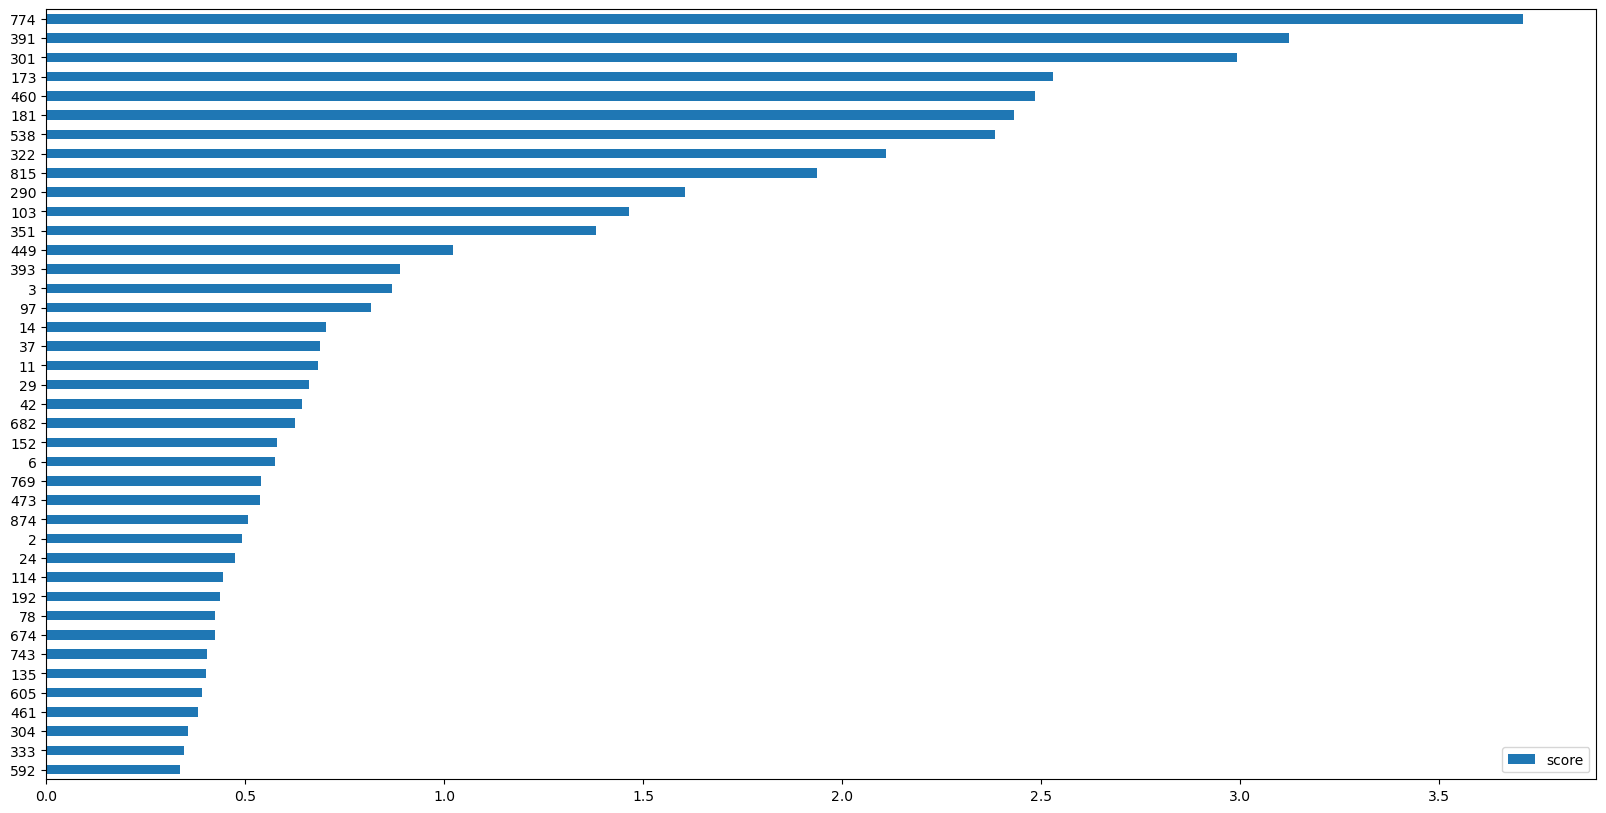

In [13]:
# # ================================
# # Feature Importance
# # ================================

# # --- 1. Extract raw feature importance ---
# booster = model.get_booster()
# feature_important = booster.get_score(importance_type='gain') 

# keys = list(feature_important.keys())
# values = list(feature_important.values())

# data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
# data.nlargest(40, columns="score").sort_values("score", ascending=True).plot(kind='barh', figsize=(20, 10))
# data.head()

## Analyze the features 

In [14]:
# import numpy as np
# import shap 

# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)

# # Get mean absolute SHAP values per feature
# shap_combined = np.sum(np.abs(shap_values), axis=0)  # Shape: (num_samples, num_features)

# # Get mean absolute SHAP values per feature
# mean_shap_values = shap_combined.mean(0)

# # Select top 20 features
# top_n = 20
# top_features = np.argsort(mean_shap_values)[-top_n:]

# # Select top 20 features
# top_n = 20
# top_features = np.argsort(mean_shap_values)[-top_n:]

# # Filter data
# X_top = X_test.iloc[:, top_features]

# # # Plot only top features
# shap.summary_plot(shap_values[:, top_features], X_top)
